# Week 5 - Feature Engineering: Traversals Part 2
### March 24, 2017

#### Objectives
  * Continue previous feature engineering efforts by exploring the following:
    1. New Regression Models: k-Nearest Neighbors, Random Forest
    2. Box Cox Transformations
    3. Addition of histograms of models' results

In [2]:
import psycopg2
from psycopg2 import extras
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import sys, os

src_abspath = os.path.abspath(os.path.join(
    os.path.split(os.getcwd())[0], 'src'))
sys.path.append(src_abspath)
from db import *
from clf import *

%matplotlib inline

## Composite Dataset

In [4]:
data = db.composite_data(interval=30)

print data.shape
data.head()

(6160, 24)


,subjectid,icustayid,readm_days,prev_iculos,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU,...,nonicu-CSRU,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU,icu_los
0,36,211200,11.425,1.1096,3,2,0,0,0,0,...,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.462,0.0,6.8595
1,41,237024,2.845,3.3937,1,2,0,0,0,0,...,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,3.1476
2,68,225771,11.418,3.5368,1,1,0,0,0,0,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.8200
3,68,272667,7.652,0.8200,1,1,0,0,0,0,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,6.3983
4,91,256972,9.576,0.4965,1,1,0,0,0,0,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,3.4750


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6160 entries, 0 to 6159
Data columns (total 24 columns):
subjectid       6160 non-null int64
icustayid       6160 non-null int64
readm_days      6160 non-null float64
prev_iculos     6160 non-null float64
n_icutrav       6160 non-null int64
curr_cu         6160 non-null int64
prev_cu         6160 non-null int64
prev_ICU        6160 non-null int64
disch_cu        6160 non-null int64
disch_ICU       6160 non-null int64
icu_in_day      6160 non-null int64
icu_out_day     6160 non-null int64
intra_risk      6160 non-null int64
nonicu-SICU     6160 non-null float64
nonicu-CSRU     6160 non-null float64
nonicu-MICU     6160 non-null float64
MICU-MICU       6160 non-null float64
nonicu-TSICU    6160 non-null float64
nonicu-CCU      6160 non-null float64
TSICU-TSICU     6160 non-null float64
SICU-SICU       6160 non-null float64
CSRU-CSRU       6160 non-null float64
CCU-CCU         6160 non-null float64
icu_los         6160 non-null float64
dty

In [40]:
data.describe()

,subjectid,icustayid,readm_days,prev_iculos,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU,...,nonicu-CSRU,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU,icu_los
count,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.0,6160.0,...,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000
mean,35899.599026,249426.524026,9.127547,5.150684,1.301299,2.263636,0.000325,0.000162,0.0,0.0,...,0.128501,0.387567,0.004591,0.073978,0.116458,0.000936,0.001812,0.013575,0.000556,5.108498
std,28844.497122,28899.427910,7.784120,7.588340,0.661220,1.350546,0.025482,0.012741,0.0,0.0,...,0.294932,0.455978,0.024462,0.251552,0.303490,0.012110,0.013520,0.068698,0.006306,7.725125
min,36.000000,200001.000000,0.001000,0.000100,1.000000,1.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000300
25%,12847.000000,224024.500000,2.811750,1.403475,1.000000,1.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.440675
50%,26229.000000,249333.500000,6.219000,2.674350,1.000000,2.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.741000
75%,58518.250000,274093.750000,13.956750,5.337550,1.000000,3.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.846000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.344900
max,99865.000000,299994.000000,29.997000,116.832700,9.000000,5.000000,2.000000,1.000000,0.0,0.0,...,2.867000,3.384000,0.404000,2.482000,1.684000,0.443000,0.251000,1.155000,0.175000,173.072500


# Predictive Modeling

## Normalization Approach 1: Standard Scaling

In [5]:
am_debugging = True
if am_debugging:
    np.random.seed(2)
else:
    np.random.seed()

#### Partition: Training & Testing Sets

In [6]:
X_train, X_test, y_train, y_test = data_partition(data.iloc[:1000, :])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((700, 23), (300, 23), (700,), (300,))

#### Normalization

In [7]:
scaled_X_train, scaled_X_test = scale(X_train, X_test)

#### Feature Selection

In [44]:
pass

### Model: Linear Regression

In [291]:
lr_model, lr_pred, lr_p, lr_score = gridsearch(scaled_X_train, scaled_X_test, y_train)
print "Best Parameters: ", lr_p
print "Best Grid Search Score: ", lr_score
print "Best Estimator: ", lr_model, "\n"

Best Parameters:  {'kernel': 'linear', 'C': 1000, 'gamma': 0.0001}
Best Grid Search Score:  0.0510005223002
Best Estimator:  SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0001,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 



#### Compare Predictions

In [292]:
lr_pred[-10:]

array([  2.53905234,   2.55147744,   6.33025238,   2.33192863,
         2.53241604,   2.83256744,  13.31739346,   2.91845799,
         1.55092954,   6.40806963])

In [293]:
y_test[-10:]

array([  4.6149,   6.8684,  13.8397,   0.3632,   1.6397,   3.0585,
         3.0521,   0.2826,   3.5426,   0.8828])

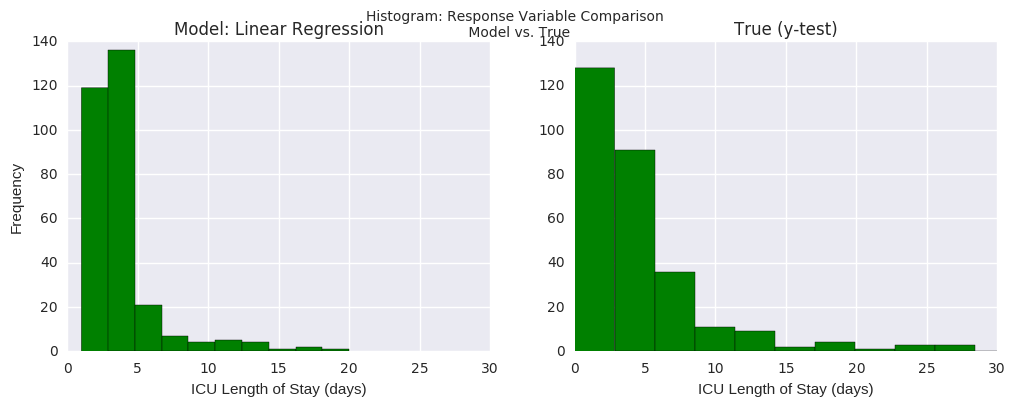

In [301]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(np.round(lr_pred), color='g')
plt.title("Model: Linear Regression")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,30])
# plt.ylim([0, 120])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,30])
# plt.ylim([0, 150])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

##### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [297]:
lr_rmse = RMSE(lr_pred, y_test)
print "RMSE = %.3f days" % lr_rmse

RMSE = 10.684 days


In [296]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,71.01]


The linear regression model has an RMSE value of 10.68 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

##### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [298]:
lr_mae = MAE(lr_pred, y_test)
print "MAE = %.3f days" % lr_mae

MAE = 1.643 days


The average difference between prediction and observation is 1.64 days, which is low.

##### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [299]:
lr_r2 = r2(lr_pred, y_test)
print "r2 = %.3f" % lr_r2

r2 = 0.074


The R<sup>2</sup> value is approximately 0.074, which is low and indicates that the model does not have strong predictive power.

### Model: Support Vector Regression

In [45]:
def gridsearch(X_train, X_test, y_train):
    """
    Function determines the optimal parameters of the best classifier model/estimator by performing a grid search.
    The best model will be fitted with the Training set and subsequently used to predict the classification/labels
    of the Testing set. The function returns the "best" classifier instance, classifier predictions, best parameters,
    and grid score.

    :param X_train: Training set features
    :param X_test: Testing set features
    :param y_train: Training set labels
    :return: tuple of (best classifier instance, clf predictions, dict of best parameters, grid score)
    """
    # Parameter Grid - dictionary of parameters (map parameter names to values to be searched)
    param_grid = [
        {'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear']},
        {'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']},
        {'C':[0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'degree': [2], 'kernel': ['poly']}
    ]

    
    # Blank clf instance
    blank_clf = SVR()

    # Grid Search - Hyperparameters Optimization
    clf = grid_search.GridSearchCV(blank_clf, param_grid, n_jobs=-1)  # classifier + optimal parameters
    clf = clf.fit(X_train, y_train)  # fitted classifier
    best_est = clf.best_estimator_
    clf_pred = best_est.predict(X_test)

    best_params = clf.best_params_  # best parameters identified by grid search
    score = clf.best_score_  # best grid score
    return (best_est, clf_pred, best_params, score)

In [46]:
svr_model, svr_pred, svr_p, svr_score = gridsearch(scaled_X_train, scaled_X_test, y_train)
print "Best Parameters: ", svr_p
print "Best Grid Search Score: ", svr_score
print "Best Estimator: ", svr_model, "\n"

Best Parameters:  {'kernel': 'linear', 'C': 1000, 'gamma': 0.0001}
Best Grid Search Score:  0.0510005223002
Best Estimator:  SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0001,
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 



Linear kernel was determined to be the most optimal for SVR model. Thus, the model is similar to Linear Regression.

#### Compare Predictions

In [47]:
svr_pred[-10:]

array([  2.53905234,   2.55147744,   6.33025238,   2.33192863,
         2.53241604,   2.83256744,  13.31739346,   2.91845799,
         1.55092954,   6.40806963])

In [48]:
y_test[-10:]

array([  4.6149,   6.8684,  13.8397,   0.3632,   1.6397,   3.0585,
         3.0521,   0.2826,   3.5426,   0.8828])

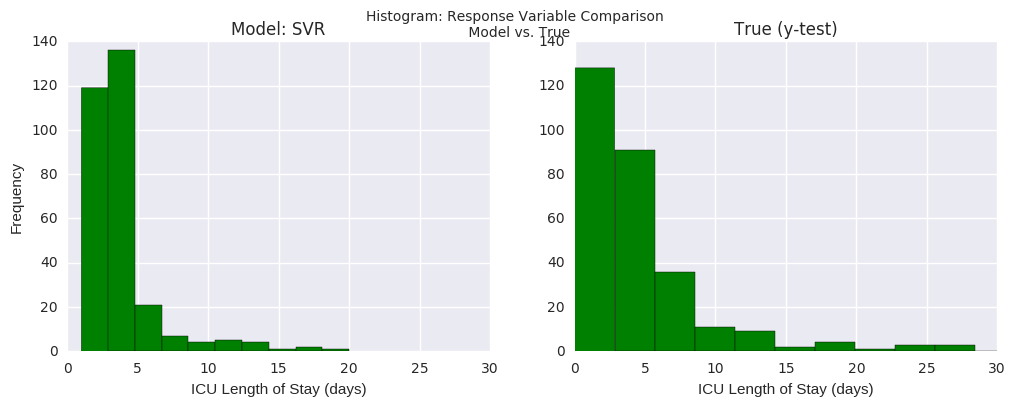

In [274]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(np.round(svr_pred), color='g')
plt.title("Model: SVR")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,30])
# plt.ylim([0, 120])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,30])
# plt.ylim([0, 150])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

##### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [236]:
svr_rmse = RMSE(svr_pred, y_test)
print "RMSE = %.3f days" % svr_rmse

RMSE = 10.684 days


In [138]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,71.01]


The SVR model has an RMSE value of 10.68 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

##### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [237]:
svr_mae = MAE(svr_pred, y_test)
print "MAE = %.3f days" % svr_mae

MAE = 1.643 days


The average difference between prediction and observation is 1.64 days, which is low.

##### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [238]:
svr_r2 = r2(svr_pred, y_test)
print "r2 = %.3f" % svr_r2

r2 = 0.074


The R<sup>2</sup> value is approximately 0.074, which is low and indicates that the model does not have strong predictive power.

### Model: k-Nearest Neighbors

In [201]:
knn_model = KNeighborsRegressor(n_neighbors=5, weights='uniform') # look at 5 closest neighbors
knn_model.fit(scaled_X_train, y_train) # fit model on training data
knn_pred = knn_model.predict(scaled_X_test)

#### Compare Predictions

In [202]:
knn_pred[-10:]

array([ 2.46158,  3.20428,  2.41194,  3.6081 ,  2.0596 ,  3.73802,
        4.74774,  4.20168,  2.08698,  3.46718])

In [203]:
y_test[-10:]

array([  4.6149,   6.8684,  13.8397,   0.3632,   1.6397,   3.0585,
         3.0521,   0.2826,   3.5426,   0.8828])

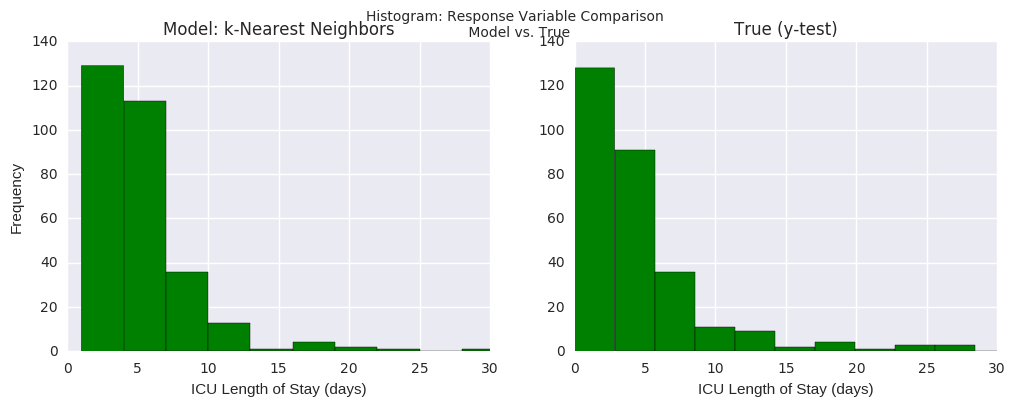

In [275]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(np.round(knn_pred), color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,30])
# plt.ylim([0, 120])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,30])
# plt.ylim([0, 150])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

##### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [239]:
knn_rmse = RMSE(knn_pred, y_test)
print "RMSE = %.3f days" % knn_rmse

RMSE = 11.705 days


In [206]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,71.01]


The k-NN model has an RMSE value of 11.71 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

##### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [240]:
knn_mae = MAE(knn_pred, y_test)
print "MAE = %.3f days" % knn_mae

MAE = 2.480 days


The average difference between prediction and observation is 2.5 days, which is relatively low.

##### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [242]:
knn_r2 = r2(knn_pred, y_test)
print "r2 = %.2f" % knn_r2

r2 = -0.11


The k-NN model has poor predictive power. The negative R<sup>2</sup> is out of range, but possible as it indicates that the model can be arbitrarily worse. 

This may be attributed to the fact that it's a "lazy learning" algorithm, *lacking generalization*. The model only does work (build a model) at the time of prediction and uses minimal, if any Training data.

### Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [212]:
def rf_gridsearch(X_train, X_test, y_train):
    # Parameter Grid - dictionary of parameters (map parameter names to values to be searched)
    param_grid = [
        {'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
         'criterion': ['mse', 'mae']}
    ]

    rfr = RandomForestRegressor(random_state=2, n_jobs=-1)

    # Grid search to find "best" random forest classifier -- Hyperparameters Optimization
    clf = grid_search.GridSearchCV(rfr, param_grid)  # classifier + optimal parameters
    clf = clf.fit(X_train, y_train)  # fitted classifier -- Training Set
    best_est = clf.best_estimator_
    clf_pred = best_est.predict(X_test)  # apply classifier on test set for label predictions
    params = clf.best_params_  # optimal parameters
    score = clf.best_score_  # best grid score
    imp = best_est.feature_importances_
    return (best_est, clf_pred, params, score, imp)

In [213]:
rf_model, rf_pred, rf_p, rf_score, rf_imp = rf_gridsearch(scaled_X_train, scaled_X_test, y_train)
print "Best Parameters: ", rf_p
print "Best Grid Search Score: ", rf_score
print "Best Estimator: ", rf_model, "\n"

Best Parameters:  {'n_estimators': 10, 'criterion': 'mae'}
Best Grid Search Score:  -0.210385016698
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=2,
           verbose=0, warm_start=False) 



#### Feature Importance

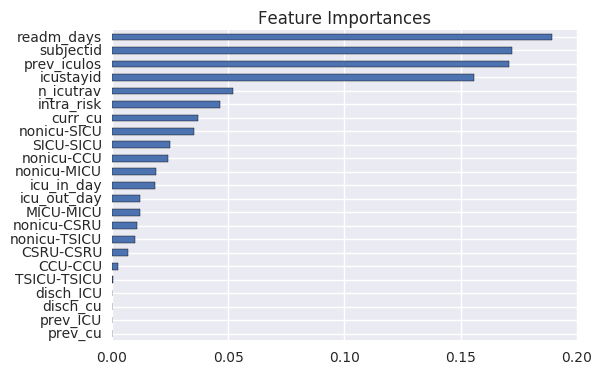

In [263]:
feats = data.drop('icu_los', axis=1)
feat_imp = pd.Series(rf_imp, 
                     index=feats.columns.values).sort_values(ascending=True)
feat_imp.plot(kind='barh')
plt.title('Feature Importances')

#### Compare Predictions

In [215]:
rf_pred[-10:]

array([  2.58516,   2.20518,   9.76718,   8.41386,   3.66734,  25.31914,
        10.44873,   2.18418,   2.71791,  16.20222])

In [216]:
y_test[-10:]

array([  4.6149,   6.8684,  13.8397,   0.3632,   1.6397,   3.0585,
         3.0521,   0.2826,   3.5426,   0.8828])

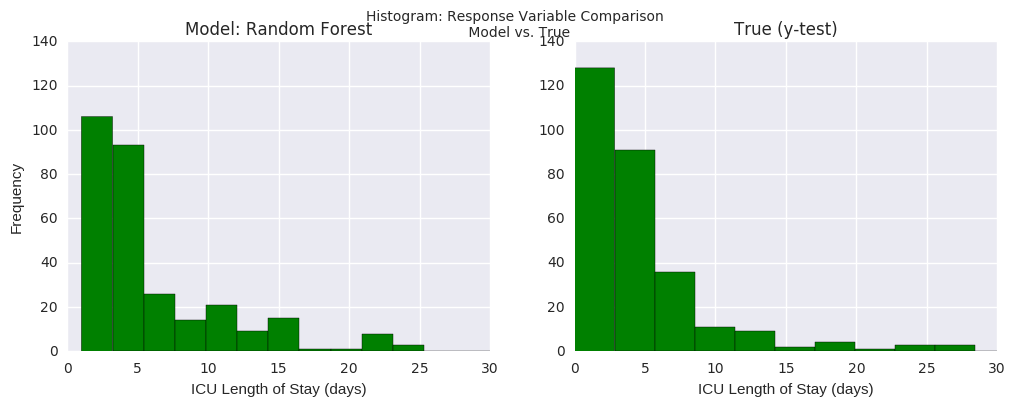

In [276]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(np.round(rf_pred), bins=19, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,30])
plt.ylim([0, 140])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,30])
plt.ylim([0, 140])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

##### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [243]:
rf_rmse = RMSE(rf_pred, y_test)
print "RMSE = %.3f days" % rf_rmse

RMSE = 10.109 days


In [234]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.00,71.01]


The Random Forest regression model has an RMSE value of 10.11 days, which is relatively low compared to the response range.

##### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [244]:
rf_mae = MAE(rf_pred, y_test)
print "MAE = %.3f days" % rf_mae

MAE = 2.531 days


The average difference between prediction and observation is 2.5 days, which is relatively low.

##### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [246]:
rf_r2 = r2(rf_pred, y_test)
print "r2 = %.2f" % rf_r2

r2 = 0.17


The Random Forest model has poor predictive power.

## Normalization Approach 2: Box Cox
Can't handle 0 values

#### Data Partition & Normalization (Box Cox)

In [8]:
data_boxcox = data.copy()
data_boxcox.readm_days = stats.boxcox(data_boxcox.readm_days)[0]
data_boxcox.prev_iculos = stats.boxcox(data_boxcox.prev_iculos)[0]
data_boxcox.n_icutrav = stats.boxcox(data_boxcox.n_icutrav)[0]

data_boxcox.head()

,subjectid,icustayid,readm_days,prev_iculos,n_icutrav,curr_cu,prev_cu,prev_ICU,disch_cu,disch_ICU,...,nonicu-CSRU,nonicu-MICU,MICU-MICU,nonicu-TSICU,nonicu-CCU,TSICU-TSICU,SICU-SICU,CSRU-CSRU,CCU-CCU,icu_los
0,36,211200,2.999182,0.104486,0.200775,2,0,0,0,0,...,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.462,0.0,6.8595
1,41,237024,1.141353,1.291416,0.000000,2,0,0,0,0,...,0.717,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,3.1476
2,68,225771,2.998265,1.337589,0.000000,1,0,0,0,0,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.8200
3,68,272667,2.419057,-0.196695,0.000000,1,0,0,0,0,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,6.3983
4,91,256972,2.738930,-0.678633,0.000000,1,0,0,0,0,...,0.000,0.846,0.0,0.0,0.0,0.0,0.0,0.000,0.0,3.4750


In [9]:
bc_X_train, bc_X_test, bc_y_train, bc_y_test = data_partition(data_boxcox.iloc[:1000, :])

bc_X_train.shape, bc_X_test.shape, bc_y_train.shape, bc_y_test.shape

((700, 23), (300, 23), (700,), (300,))

### Model: Linear Regression

In [ ]:
lr_model_bc, lr_pred_bc, lr_p_bc, lr_score_bc = gridsearch(bc_X_train, bc_X_test, bc_y_train)
print "Best Parameters: ", lr_p_bc
print "Best Grid Search Score: ", lr_score_bc
print "Best Estimator: ", lr_model_bc

#### Compare Predictions

In [292]:
lr_pred_bc[-10:]

array([  2.53905234,   2.55147744,   6.33025238,   2.33192863,
         2.53241604,   2.83256744,  13.31739346,   2.91845799,
         1.55092954,   6.40806963])

In [293]:
bc_y_test[-10:]

array([  4.6149,   6.8684,  13.8397,   0.3632,   1.6397,   3.0585,
         3.0521,   0.2826,   3.5426,   0.8828])

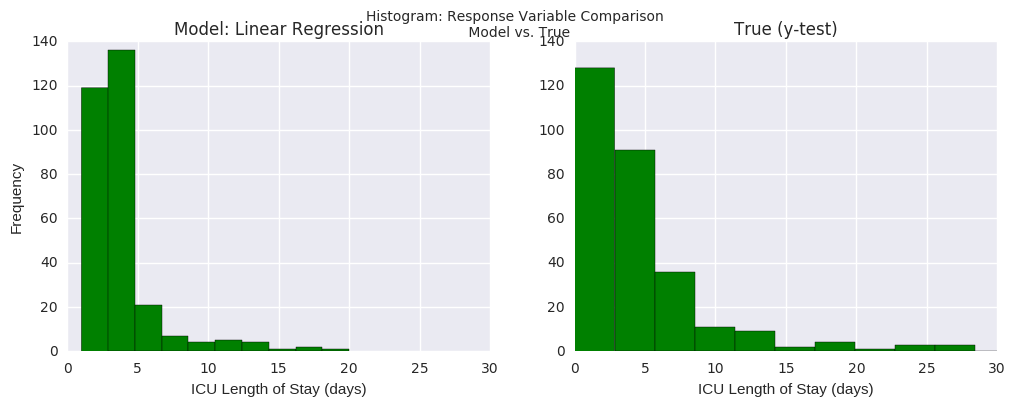

In [301]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(np.round(lr_pred_bc), color='g')
plt.title("Model: Linear Regression")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,30])
# plt.ylim([0, 120])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(bc_y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,30])
# plt.ylim([0, 150])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

##### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [297]:
lr_rmse_bc = RMSE(lr_pred_bc, bc_y_test)
print "RMSE = %.3f days" % lr_rmse_bc

RMSE = 10.684 days


In [296]:
print "[%.2f,%.2f]" % (bc_y_test.min(), bc_y_test.max())

[0.00,71.01]


The linear regression model has an RMSE value of 10.68 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

##### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [298]:
lr_mae_bc = MAE(lr_pred_bc, bc_y_test)
print "MAE = %.3f days" % lr_mae_bc

MAE = 1.643 days


The average difference between prediction and observation is 1.64 days, which is low.

##### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [299]:
lr_r2_bc = r2(lr_pred_bc, bc_y_test)
print "r2 = %.3f" % lr_r2_bc

r2 = 0.074


The R<sup>2</sup> value is approximately 0.074, which is low and indicates that the model does not have strong predictive power.

### Model: Support Vector Regression

In [ ]:
svr_model_bc, svr_pred_bc, svr_p_bc, svr_score_bc = gridsearch(bc_X_train, bc_X_test, bc_y_train)
print "Best Parameters: ", svr_p_bc
print "Best Grid Search Score: ", svr_score_bc
print "Best Estimator: ", svr_model_bc, "\n"

#### Compare Predictions

In [ ]:
svr_pred_bc[-10:]

In [ ]:
bc_y_test[-10:]

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(np.round(svr_pred_bc), color='g')
plt.title("Model: SVR")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,30])
# plt.ylim([0, 120])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(bc_y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,30])
# plt.ylim([0, 150])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

##### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [ ]:
svr_rmse_bc = RMSE(svr_pred_bc, bc_y_test)
print "RMSE = %.3f days" % svr_rmse_bc

In [ ]:
print "[%.2f,%.2f]" % (bc_y_test.min(), bc_y_test.max())

The SVR model has an RMSE value of 10.68 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

##### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [ ]:
svr_mae_bc = MAE(svr_pred_bc, bc_y_test)
print "MAE = %.3f days" % svr_mae_bc

The average difference between prediction and observation is 1.64 days, which is low.

##### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [ ]:
svr_r2_bc = r2(svr_pred_bc, bc_y_test)
print "r2 = %.3f" % svr_r2_bc

The R<sup>2</sup> value is approximately 0.074, which is low and indicates that the model does not have strong predictive power.

### Model: k-Nearest Neighbors

In [305]:
knn_model_bc = KNeighborsRegressor(n_neighbors=5, weights='uniform') # look at 5 closest neighbors
knn_model_bc.fit(bc_X_train, bc_y_train) # fit model on training data
knn_pred_bc = knn_model_bc.predict(bc_X_test)

#### Compare Predictions

In [306]:
knn_pred_bc[-10:]

array([ 10.64734,  19.50714,   3.04354,   8.58866,   4.28306,   2.67076,
         8.39404,   2.49932,   3.41412,   7.64912])

In [307]:
bc_y_test[-10:]

array([  4.6149,   6.8684,  13.8397,   0.3632,   1.6397,   3.0585,
         3.0521,   0.2826,   3.5426,   0.8828])

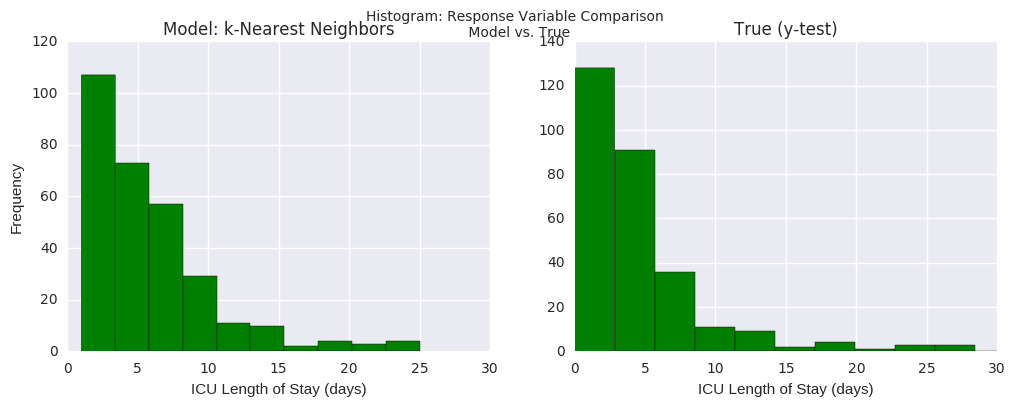

In [308]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(np.round(knn_pred_bc), color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,30])
# plt.ylim([0, 120])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(bc_y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,30])
# plt.ylim([0, 150])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

##### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [309]:
knn_rmse_bc = RMSE(knn_pred_bc, bc_y_test)
print "RMSE = %.3f days" % knn_rmse_bc

RMSE = 12.047 days


In [310]:
print "[%.2f,%.2f]" % (bc_y_test.min(), bc_y_test.max())

[0.00,71.01]


##### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [311]:
knn_mae_bc = MAE(knn_pred_bc, bc_y_test)
print "MAE = %.3f days" % knn_mae_bc

MAE = 2.864 days


##### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [312]:
knn_r2_bc = r2(knn_pred_bc, bc_y_test)
print "r2 = %.2f" % knn_r2_bc

r2 = -0.18


### Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [313]:
rf_model_bc, rf_pred_bc, rf_p_bc, rf_score_bc, rf_imp_bc = rf_gridsearch(bc_X_train, bc_X_test, bc_y_train)
print "Best Parameters: ", rf_p_bc
print "Best Grid Search Score: ", rf_score_bc
print "Best Estimator: ", rf_model_bc, "\n"

Best Parameters:  {'n_estimators': 10, 'criterion': 'mae'}
Best Grid Search Score:  -0.212798474376
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=2,
           verbose=0, warm_start=False) 



#### Feature Importance

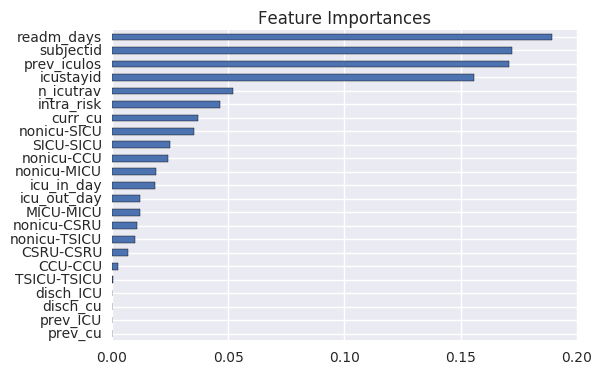

In [318]:
feats_bc = data_boxcox.drop('icu_los', axis=1)
feat_imp_bc = pd.Series(rf_imp_bc, 
                     index=feats_bc.columns.values).sort_values(ascending=True)
feat_imp_bc.plot(kind='barh')
plt.title('Feature Importances')

#### Compare Predictions

In [319]:
rf_pred_bc[-10:]

array([  2.58516,   2.20518,   9.76718,   8.41386,   3.66734,  25.31914,
        10.44873,   2.18418,   2.71791,  16.20222])

In [320]:
bc_y_test[-10:]

array([  4.6149,   6.8684,  13.8397,   0.3632,   1.6397,   3.0585,
         3.0521,   0.2826,   3.5426,   0.8828])

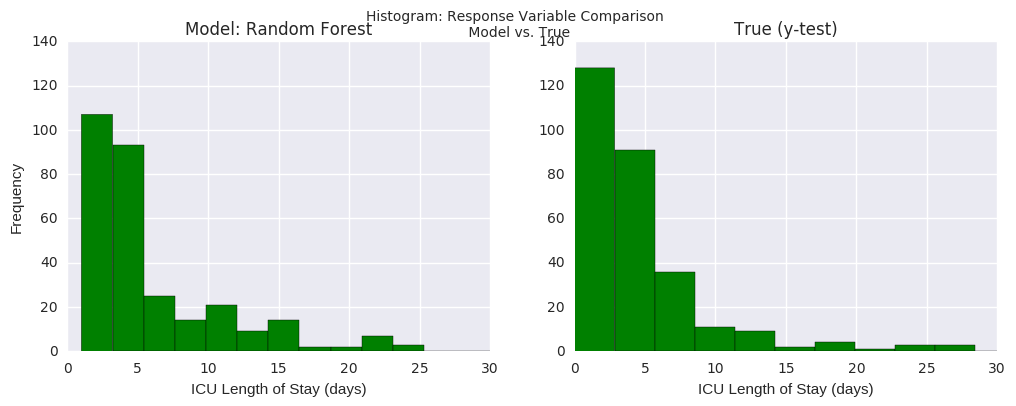

In [321]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(np.round(rf_pred_bc), bins=19, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,30])
plt.ylim([0, 140])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(bc_y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,30])
plt.ylim([0, 140])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

##### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [322]:
rf_rmse_bc = RMSE(rf_pred_bc, bc_y_test)
print "RMSE = %.3f days" % rf_rmse_bc

RMSE = 10.083 days


In [323]:
print "[%.2f,%.2f]" % (bc_y_test.min(), bc_y_test.max())

[0.00,71.01]


##### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [324]:
rf_mae_bc = MAE(rf_pred_bc, bc_y_test)
print "MAE = %.3f days" % rf_mae_bc

MAE = 2.531 days


##### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [325]:
rf_r2_bc = r2(rf_pred_bc, bc_y_test)
print "r2 = %.2f" % rf_r2_bc

r2 = 0.18


## Conclusion
Model | RMSE | MAE | R<sup>2</sup> |
:-----|:----:|:---:| :------------:|
Linear Regression|10.68|1.64|0.07
Support Vector Regression (*kernel: linear*)|10.68|1.64|0.07
k-Nearest Neighbors|11.71|2.48|-0.11
Random Forest|10.11|2.53|0.17

All regression models have roughly similar metrics. It should be noted that Support Vector Regression has the exact same outputs and metrics as Linear Regression as the *linear kernel* was determined to be the most optimal parameter from a cross-validation grid search. Both models are similar as a linear plane is used to instantiate and fit both models.

#### RMSE
In regards to RMSE, the models have relatively decent performances in the prediction of ICU length of stay for new, unseen data. The RMSE values are greater than the MAE values for all models, suggesting that there are a higher frequency of larger residuals as the metric penalizes bigger discrepancies.

#### MAE
All models are very strong in terms of their mean absolute errors with values ranging from 1-3 days for the ICU length of stays. Essentially, the models are only off, on average, 1-3 days in their prediction.

#### R<sup>2</sup> - Coefficient of Determination
The very low R<sup>2</sup> values indicate that the models have very poor predictive power. 

More specifically, the k-Nearest Neighbors model is the weakest model and has a negative coefficient of determination. This suggests that the model is not generalizable to future unseen data and is possibly attributed to the fact that it's approach is "lazy learning". The model does not encompass a training phase and instead holds the entire training data and builds its model at the time of prediction. A drawback of this approach is longer run-time.

### Box Cox Transformation
Box Cox transformation was performed on only the following features: `readm_days`, `prev_iculos`, and `n_icutrav`. These features are the only ones that have positive values and are continuous. Other unapplicable features either had non-positive values or were categorical in nature.

Model | RMSE | MAE | R<sup>2</sup> |
:-----|:----:|:---:| :------------:|
Linear Regression|||
Support Vector Regression (*kernel: linear*)|||
k-Nearest Neighbors|12.05|2.86|-0.18
Random Forest|10.08|2.53|0.18

This normalization approach gave no improvements to the model. All metrics evaluating the performance of the regression models actually worsened from the transformation.